# Preprocessing

### Import necessary modules

In [39]:
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import IsoelectricPoint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

### Read training data

In [2]:
dataCyto=[]
for record in SeqIO.parse("cyto.fasta.txt", "fasta"):
    dataCyto.append(record)
    
dataMito=[]
for record in SeqIO.parse("mito.fasta.txt", "fasta"):
    dataMito.append(record)
    
dataNucleus=[]
for record in SeqIO.parse("nucleus.fasta.txt", "fasta"):
    dataNucleus.append(record)
    
dataSecreted=[]
for record in SeqIO.parse("secreted.fasta.txt", "fasta"):
    dataSecreted.append(record)

print('cyto', len(dataCyto))
print('mito', len(dataMito))
print('nucleus', len(dataNucleus))
print('secreted', len(dataSecreted))

cyto 3004
mito 1299
nucleus 3314
secreted 1605


In [3]:
#example of data
print(dataCyto[0])

ID: sp|Q4JIM5|ABL2_MOUSE
Name: sp|Q4JIM5|ABL2_MOUSE
Description: sp|Q4JIM5|ABL2_MOUSE Abelson tyrosine-protein kinase 2 OS=Mus musculus GN=Abl2 PE=1 SV=1
Number of features: 0
Seq('MGQQVGRVGEAPGLQQPQPRGIRGSSAARPSGRRRDPAGRTADAGFNVFTQHDH...VQR', SingleLetterAlphabet())


### Analyse the data to get features

In [4]:
analysed=[]
for i in range(len(dataCyto)):
    analysed_seq=ProteinAnalysis(str(dataCyto[i].seq))
    analysed.append(analysed_seq)
    
for i in range(len(dataMito)):
    analysed_seq=ProteinAnalysis(str(dataMito[i].seq))
    analysed.append(analysed_seq)
    
for i in range(len(dataNucleus)):
    analysed_seq=ProteinAnalysis(str(dataNucleus[i].seq))
    analysed.append(analysed_seq)
    
for i in range(len(dataSecreted)):
    analysed_seq=ProteinAnalysis(str(dataSecreted[i].seq))
    analysed.append(analysed_seq)
print(len(analysed))   

9222


In [5]:
#example of analysed data
print('length:', analysed[0].length)
print('aminoacids',analysed[0].count_amino_acids())
print('aminoacid percent',analysed[0].amino_acids_percent)
print('molecular weight',analysed[0].molecular_weight())

length: 1182
aminoacids {'A': 97, 'C': 17, 'D': 51, 'E': 81, 'F': 35, 'G': 96, 'H': 26, 'I': 30, 'K': 72, 'L': 99, 'M': 22, 'N': 40, 'P': 96, 'Q': 44, 'R': 63, 'S': 118, 'T': 73, 'V': 77, 'W': 13, 'Y': 32}
aminoacid percent None
molecular weight 128194.98120000077


### Features

In [6]:
noOfExamples=len(dataCyto)+len(dataMito)+len(dataNucleus)+len(dataSecreted)
composition=np.zeros((noOfExamples, 20))
for i in range(len(analysed)):
    dict=analysed[i].get_amino_acids_percent()
    for pos,aa in enumerate(dict.values()):
        composition[i,pos]=aa

In [7]:
length=np.zeros((noOfExamples, 1))
for i in range(len(analysed)):
    length[i,0]=analysed[i].length

iep=np.zeros((len(analysed), 1))
for i in range(len(analysed)):
    iep[i,0]=analysed[i].isoelectric_point()

noOfFeatures=22
features=np.zeros((noOfExamples,noOfFeatures))
features=np.append(np.append(composition, length,axis=1),iep, axis=1)



In [8]:
d=dataCyto[1]
name='sp|P15891|ABP1_YEAST'
seq=d.seq
desc='Actin-binding protein OS=Saccharomyces cerevisiae (strain ATCC 204508 / S288c) GN=ABP1 PE=1 SV=4'
print('Name:')
print(name)
print('Description:')
print(desc)  
print('Sequence: (592 aminoacids)')
print(seq[:95])
print(seq[95:190])
print(seq[190:285])
print(seq[285:380])
print(seq[380:475])
print(seq[475:570])
print(seq[570:])

          

Name:
sp|P15891|ABP1_YEAST
Description:
Actin-binding protein OS=Saccharomyces cerevisiae (strain ATCC 204508 / S288c) GN=ABP1 PE=1 SV=4
Sequence: (592 aminoacids)
MALEPIDYTTHSREIDAEYLKIVRGSDPDTTWLIISPNAKKEYEPESTGSSFHDFLQLFDETKVQYGLARVSPPGSDVEKIIIIGWCPDSAPLKT
RASFAANFAAVANNLFKGYHVQVTARDEDDLDENELLMKISNAAGARYSIQTSSKQQGKASTPPVKKSFTPSKSPAPVSKKEPVKTPSPAPAAKI
SSRVNDNNDDDDWNEPELKERDFDQAPLKPNQSSYKPIGKIDLQKVIAEEKAKEDPRLVQKPTAAGSKIDPSSDIANLKNESKLKRDSEFNSFLG
TTKPPSMTESSLKNDDDKVIKGFRNEKSPAQLWAERKAKQNSGNAETKAEAPKPEVPEDEPEGEPDVKDLKSKFEGLAASEKEEEEMENKFAPPP
KKSEPTIISPKPFSKPQEPVKAEEAEQPKTDYKKIGNPLPGMHIEADNEEEPEENDDDWDDDEDEAAQPPLPSRNVASGAPVQKEEPEQEEIAPS
LPSRNSIPAPKQEEAPEQAPEEEIEEEAEEAAPQLPSRSSAAPPPPPRRATPEKKPKENPWATAEYDYDAAEDNELTFVENDKIINIEFVDDDWW
LGELEKDGSKGLFPSNYVSLGN


In [9]:
#example of analysed data
print('length:', analysed[1].length)
print('isoelectric point:',float(np.round(iep[1],3)))
print('amino acid composition:')

amac=analysed[1].amino_acids_percent
keys=[]
values=[]
for key,value in (amac.items()):
    keys.append(key)
    values.append(value)
for i in np.arange(0,20, 3):
    if i==18:
        print(keys[i],':', np.round(values[i]*100,2),'%,', keys[i+1],':', np.round(values[i+1]*100,2), '%')
    else:
        print(keys[i],':', np.round(values[i]*100,2),'%,', keys[i+1],':', np.round(values[i+1]*100,2), '%' ,keys[i+2],':', np.round(values[i+2]*100,2), '%')




length: 592
isoelectric point: 4.589
amino acid composition:
A : 9.46 %, C : 0.17 % D : 7.94 %
E : 12.67 %, F : 2.87 % G : 3.72 %
H : 0.68 %, I : 4.73 % K : 9.97 %
L : 5.24 %, M : 0.84 % N : 5.07 %
P : 11.15 %, Q : 3.38 % R : 2.87 %
S : 8.61 %, T : 3.72 % V : 3.72 %
W : 1.35 %, Y : 1.86 %


### Labels

In [10]:
#labels for each dataset
labels=np.zeros(noOfExamples)

labels[0:len(dataCyto)]=1
labels[len(dataCyto):len(dataCyto)+len(dataMito)]=2
labels[len(dataCyto)+len(dataMito):len(dataCyto)+len(dataMito)+len(dataNucleus)]=3
labels[len(dataCyto)+len(dataMito)+len(dataNucleus):]=4

In [11]:
enc=OneHotEncoder(labels)
enc.categories

array([1., 1., 1., ..., 4., 4., 4.])

# Model exploration

### Comparing results for different models and for different datasets

In [12]:
model2=svm.NuSVC(nu=0.5, decision_function_shape='ovo', probability=True)
model2.fit(composition, enc.categories)
print('NuSVC trained on composition, score:', model2.score(composition, enc.categories))

NuSVC trained on composition, score: 0.7006072435480373


In [13]:
#grid search for best parameter:
indexes=np.arange(0.1,0.52,0.02)
exploreScores=np.zeros(len(indexes))
for i,nu in enumerate(indexes):
    modelx=svm.NuSVC(nu=nu, decision_function_shape='ovo', probability=True)
    modelx.fit(composition, enc.categories)
    exploreScores[i]=modelx.score(composition, enc.categories)


In [15]:
print(exploreScores)
print('bestScore:',np.max(exploreScores))
print(np.argmax(exploreScores))
best=indexes[int(np.argmax(exploreScores))]
print('best parameter:',best)

[0.87063544 0.88928649 0.88646714 0.88874431 0.89058773 0.88147907
 0.88147907 0.87020169 0.86109304 0.84829755 0.83506831 0.81967035
 0.80676643 0.79191065 0.77792236 0.76718716 0.75287356 0.74213836
 0.7279332  0.71437866 0.70060724]
bestScore: 0.8905877250054218
4
best parameter: 0.18000000000000002


In [16]:
#best nu=0.18
model=svm.NuSVC(nu=np.round(best,2), decision_function_shape='ovo', probability=True)
model.fit(composition, enc.categories)
print('NuSVC trained on composition with best parameter, score:', model.score(composition, enc.categories))

NuSVC trained on composition with best parameter, score: 0.8905877250054218


In [17]:
model11=svm.SVC(C=1.0,decision_function_shape='ovo', probability=True)
model11.fit(composition, enc.categories)
print('SVC trained on composition, score:', model11.score(composition, enc.categories))

SVC trained on composition, score: 0.6477987421383647


In [18]:
   
#grid search for best parameter:
indexesC=np.arange(1,30,2)
searchScores=np.zeros(len(indexesC))
for i,c in enumerate(indexesC):
    model=svm.SVC(C=c,decision_function_shape='ovo', probability=True)
    model.fit(composition, enc.categories)
    searchScores[i]=model.score(composition, enc.categories)

In [19]:

print(searchScores)
print('bestScore:',np.max(searchScores))
print(np.argmax(searchScores))
bestC=indexesC[int(np.argmax(searchScores))]
print('best parameter:',bestC)

[0.64779874 0.68325743 0.69963132 0.71199306 0.71969204 0.72880069
 0.73704186 0.74268055 0.74907829 0.75233138 0.75547604 0.75959662
 0.76176534 0.76534374 0.76957276]
bestScore: 0.7695727607894166
14
best parameter: 29


In [20]:
model3=svm.SVC(C=bestC,decision_function_shape='ovo', probability=True)
model3.fit(composition, enc.categories)
print('SVC trained on composition, score:', model3.score(composition, enc.categories))

SVC trained on composition, score: 0.7695727607894166


In [21]:
#best models: model and model6
print('model parameters:',)
model3.get_params()

model parameters:


{'C': 29,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovo',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [22]:
model8=svm.SVC(decision_function_shape='ovo', probability=True)
model8.fit(length, enc.categories)
print('SVC trained on sequence length, score:', model8.score(length, enc.categories))

SVC trained on sequence length, score: 0.43103448275862066


In [23]:
model9=svm.SVC(decision_function_shape='ovo', probability=True)
model9.fit(iep, enc.categories)
print('SVC trained on isoelectric point, score:', model9.score(iep, enc.categories))

SVC trained on isoelectric point, score: 0.405985686402082


In [24]:

model4=svm.SVC(C=10.0,decision_function_shape='ovo', probability=True)
model4.fit(features, enc.categories)
print('SVC trained on all features, score:', model4.score(features, enc.categories))


SVC trained on all features, score: 0.4308176100628931


In [25]:
model10=svm.NuSVC(nu=0.5, decision_function_shape='ovo', probability=True)
model10.fit(length, enc.categories)
print('NuSVC trained on sequence length, score:', model10.score(length, enc.categories))

NuSVC trained on sequence length, score: 0.2852960312296682


In [26]:
model11=svm.NuSVC(nu=0.5, decision_function_shape='ovo', probability=True)
model11.fit(iep, enc.categories)
print('NuSVC trained on isoelectric point, score:', model11.score(iep, enc.categories))

NuSVC trained on isoelectric point, score: 0.27521145087833443


In [27]:
model5=svm.NuSVC(nu=0.5, decision_function_shape='ovo', probability=True)
model5.fit(features, enc.categories)
print('NuSVC trained on features, score:', model5.score(features, enc.categories))

NuSVC trained on features, score: 0.4097809585773151


In [28]:
#one classifier per class
model6 = OneVsRestClassifier(model).fit(composition, enc.categories)
print('OneVsRestClassifier trained on all model1, score:', model6.score(composition, enc.categories))

OneVsRestClassifier trained on all model1, score: 0.773801778356105


In [29]:
#best models: model and model6
print('model parameters:',)
model.get_params()

model parameters:


{'C': 29,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovo',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [30]:
print('model6 parameters:',)
model6.get_params()

model6 parameters:


{'estimator__C': 29,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovo',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': True,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(C=29, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
     verbose=False),
 'n_jobs': None}

### Cross validation

In [32]:
predsTrain1=model.predict(composition)
corrTrain1=np.corrcoef(predsTrain1, enc.categories)
probsTrain1=model.predict_proba(composition)
predProbsTrain1=np.array(np.argmax(probsTrain1, axis=1)+1)
conf1=np.array(np.max(probsTrain1, axis=1))
print('score 1:', model.score(composition, enc.categories))
print('correlation 1:',corrTrain1[1,0])
print('average confidence 1:', np.average(conf1))

predsTrain6=model6.predict(composition)
corrTrain6=np.corrcoef(predsTrain6, enc.categories)
probsTrain6=model6.predict_proba(composition)
print('score 6:', model6.score(composition, enc.categories))
print('correlation 6:',corrTrain6[1,0])
predProbsTrain6=np.array(np.argmax(probsTrain6, axis=1)+1)
conf6=np.array(np.max(probsTrain6, axis=1))
print('average confidence 6:', np.average(conf6))




score 1: 0.7695727607894166
correlation 1: 0.6763081755747868
average confidence 1: 0.6155624635951701
score 6: 0.773801778356105
correlation 6: 0.6792502256547375
average confidence 6: 0.5973467259074295


In [33]:

## if the two models agree then great, otherwise pick the prediction with max probability

print("Compare two predictions:")
myPredsTrain=np.zeros((len(analysed), 2))

for i in range(len(analysed)):
    if predsTrain1[i]==predsTrain6[i]:
        ans=predsTrain1[i]
        ansprob=max(probsTrain1[i, int(predsTrain6[i]-1)], probsTrain6[i, int(predsTrain6[i]-1)])
        print('index:', i, 'prediction:', ans, 'with prob', ansprob)
    else:
        a=np.max(probsTrain1[i])
        b=np.max(probsTrain6[i])
        if a>b:
            ans=np.argmax(probsTrain1[i])+1
            ansprob=np.max(probsTrain1[i])
        else:
            ans=np.argmax(probsTrain6[i])+1
            ansprob=np.max(probsTrain6[i])
        print('index:',i, 'decide', ans, 'with prob', ansprob)
    myPredsTrain[i]=ans,ansprob

Compare two predictions:
index: 0 decide 3 with prob 0.4895687423690284
index: 1 prediction: 1.0 with prob 0.6658980596839909
index: 2 prediction: 1.0 with prob 0.48735582507082714
index: 3 prediction: 1.0 with prob 0.6609616427680769
index: 4 prediction: 1.0 with prob 0.616093395784446
index: 5 prediction: 1.0 with prob 0.5005314097674952
index: 6 prediction: 3.0 with prob 0.6529810971226947
index: 7 prediction: 1.0 with prob 0.46816227766236407
index: 8 prediction: 1.0 with prob 0.6855590518261763
index: 9 prediction: 1.0 with prob 0.6685938821615934
index: 10 prediction: 1.0 with prob 0.6953209712125541
index: 11 prediction: 1.0 with prob 0.5378936528116167
index: 12 prediction: 1.0 with prob 0.5219228726359902
index: 13 prediction: 3.0 with prob 0.5357015297293066
index: 14 prediction: 3.0 with prob 0.5831037159381623
index: 15 prediction: 1.0 with prob 0.5227957964542795
index: 16 prediction: 1.0 with prob 0.5170290314529387
index: 17 prediction: 1.0 with prob 0.6631686777533011
i

index: 371 prediction: 1.0 with prob 0.5920396516914787
index: 372 prediction: 1.0 with prob 0.6479467111757173
index: 373 prediction: 3.0 with prob 0.4791525067415795
index: 374 decide 3 with prob 0.4382196986083336
index: 375 prediction: 1.0 with prob 0.5024666447284146
index: 376 prediction: 1.0 with prob 0.5556219405107454
index: 377 prediction: 2.0 with prob 0.35038596927793647
index: 378 prediction: 1.0 with prob 0.7747667361576691
index: 379 prediction: 1.0 with prob 0.6726555890535166
index: 380 prediction: 1.0 with prob 0.46910160945229745
index: 381 prediction: 1.0 with prob 0.7244221256715799
index: 382 prediction: 1.0 with prob 0.4766818458735253
index: 383 prediction: 1.0 with prob 0.4980261214757416
index: 384 prediction: 1.0 with prob 0.5956978895516927
index: 385 prediction: 1.0 with prob 0.6707987248498438
index: 386 prediction: 2.0 with prob 0.37479044806142137
index: 387 prediction: 3.0 with prob 0.5541286549296524
index: 388 prediction: 3.0 with prob 0.6953692264688

index: 785 prediction: 1.0 with prob 0.5303584199949375
index: 786 prediction: 3.0 with prob 0.5131234690591413
index: 787 prediction: 1.0 with prob 0.6215777967970916
index: 788 prediction: 1.0 with prob 0.5819166613533421
index: 789 prediction: 1.0 with prob 0.5760227090662974
index: 790 prediction: 1.0 with prob 0.5573463234492835
index: 791 prediction: 3.0 with prob 0.556406821222583
index: 792 prediction: 1.0 with prob 0.782204915602712
index: 793 prediction: 1.0 with prob 0.63817470657581
index: 794 prediction: 1.0 with prob 0.6185794001461021
index: 795 prediction: 1.0 with prob 0.5947766772411912
index: 796 prediction: 1.0 with prob 0.6644882270298289
index: 797 prediction: 3.0 with prob 0.5167607580623553
index: 798 prediction: 1.0 with prob 0.6805176829292763
index: 799 prediction: 1.0 with prob 0.6633492916536876
index: 800 prediction: 1.0 with prob 0.680211312648503
index: 801 decide 3 with prob 0.4664559635600603
index: 802 prediction: 3.0 with prob 0.5300380881194257
inde

index: 1160 decide 3 with prob 0.45584645708152816
index: 1161 prediction: 3.0 with prob 0.5531602797174561
index: 1162 prediction: 1.0 with prob 0.7780789616131837
index: 1163 prediction: 1.0 with prob 0.6543094048708287
index: 1164 prediction: 1.0 with prob 0.6423843860385329
index: 1165 decide 3 with prob 0.44515436239276984
index: 1166 prediction: 1.0 with prob 0.4523703970654304
index: 1167 prediction: 3.0 with prob 0.501054598497029
index: 1168 prediction: 1.0 with prob 0.5521518618684473
index: 1169 prediction: 1.0 with prob 0.6308402398426437
index: 1170 prediction: 1.0 with prob 0.538951887494292
index: 1171 decide 3 with prob 0.48921132967294384
index: 1172 prediction: 1.0 with prob 0.6230833613902385
index: 1173 prediction: 1.0 with prob 0.7087676991972376
index: 1174 prediction: 1.0 with prob 0.6383959467714494
index: 1175 decide 3 with prob 0.4825120564293542
index: 1176 prediction: 1.0 with prob 0.5830396341732046
index: 1177 prediction: 3.0 with prob 0.531338460140065
in

index: 1573 prediction: 3.0 with prob 0.6808623130372916
index: 1574 prediction: 1.0 with prob 0.5935608776341186
index: 1575 prediction: 3.0 with prob 0.4427073428147642
index: 1576 prediction: 1.0 with prob 0.3900084498256727
index: 1577 prediction: 1.0 with prob 0.5179103279161495
index: 1578 prediction: 1.0 with prob 0.5097250862587869
index: 1579 prediction: 1.0 with prob 0.5254778916994459
index: 1580 prediction: 1.0 with prob 0.6640378091739138
index: 1581 prediction: 1.0 with prob 0.5655006533769994
index: 1582 prediction: 1.0 with prob 0.6704661934922239
index: 1583 prediction: 1.0 with prob 0.6313164920637653
index: 1584 prediction: 1.0 with prob 0.7486823744280302
index: 1585 prediction: 1.0 with prob 0.6508594464081214
index: 1586 prediction: 4.0 with prob 0.6562741781427015
index: 1587 prediction: 1.0 with prob 0.6257493805018763
index: 1588 prediction: 4.0 with prob 0.7694229309837372
index: 1589 prediction: 1.0 with prob 0.5616063565795733
index: 1590 prediction: 2.0 wit

index: 1929 prediction: 1.0 with prob 0.5409697355854051
index: 1930 prediction: 1.0 with prob 0.6392340085160069
index: 1931 prediction: 1.0 with prob 0.6994415226269367
index: 1932 prediction: 1.0 with prob 0.5637659387664308
index: 1933 prediction: 2.0 with prob 0.5913156642177936
index: 1934 decide 1 with prob 0.4454385993470937
index: 1935 prediction: 1.0 with prob 0.6981178202506981
index: 1936 prediction: 1.0 with prob 0.7261943580257216
index: 1937 prediction: 1.0 with prob 0.5577624590413587
index: 1938 prediction: 1.0 with prob 0.44675845948380816
index: 1939 prediction: 1.0 with prob 0.6111166375609707
index: 1940 decide 3 with prob 0.43773723204812115
index: 1941 prediction: 3.0 with prob 0.5479046848701825
index: 1942 prediction: 1.0 with prob 0.4506711421200761
index: 1943 prediction: 1.0 with prob 0.620726479976118
index: 1944 prediction: 1.0 with prob 0.574696201147319
index: 1945 prediction: 1.0 with prob 0.5547165727774384
index: 1946 prediction: 1.0 with prob 0.68903

index: 2372 decide 3 with prob 0.4849135339517967
index: 2373 prediction: 1.0 with prob 0.4901923044933153
index: 2374 decide 3 with prob 0.5286175288844214
index: 2375 prediction: 1.0 with prob 0.5283549176316953
index: 2376 prediction: 3.0 with prob 0.6206082980307515
index: 2377 prediction: 3.0 with prob 0.6025075023072354
index: 2378 prediction: 3.0 with prob 0.5061381223542554
index: 2379 prediction: 1.0 with prob 0.561052688577497
index: 2380 prediction: 1.0 with prob 0.5362893111824412
index: 2381 prediction: 1.0 with prob 0.657150753210589
index: 2382 prediction: 1.0 with prob 0.6539800750062934
index: 2383 prediction: 1.0 with prob 0.6061399959483308
index: 2384 prediction: 3.0 with prob 0.5571985442154042
index: 2385 prediction: 2.0 with prob 0.43893248286658926
index: 2386 prediction: 1.0 with prob 0.563152452541267
index: 2387 prediction: 1.0 with prob 0.6396183049142522
index: 2388 prediction: 1.0 with prob 0.6844127189801154
index: 2389 decide 3 with prob 0.56307784402363

index: 2827 prediction: 4.0 with prob 0.4516261789497122
index: 2828 decide 3 with prob 0.4719546574416807
index: 2829 prediction: 1.0 with prob 0.773615134046012
index: 2830 prediction: 1.0 with prob 0.5168100013914425
index: 2831 prediction: 1.0 with prob 0.7181292658550029
index: 2832 prediction: 1.0 with prob 0.5991816855588588
index: 2833 prediction: 1.0 with prob 0.6539861264248754
index: 2834 prediction: 1.0 with prob 0.47355127630967075
index: 2835 prediction: 1.0 with prob 0.5062964306386945
index: 2836 prediction: 1.0 with prob 0.6862970569490717
index: 2837 prediction: 3.0 with prob 0.5027853883164339
index: 2838 prediction: 1.0 with prob 0.5337434716511672
index: 2839 prediction: 1.0 with prob 0.49438065949533755
index: 2840 prediction: 1.0 with prob 0.6804630146245794
index: 2841 decide 1 with prob 0.4576733617037398
index: 2842 prediction: 3.0 with prob 0.6129524403540907
index: 2843 prediction: 2.0 with prob 0.6349410442020688
index: 2844 prediction: 3.0 with prob 0.6227

index: 3093 decide 3 with prob 0.4609561910566293
index: 3094 prediction: 2.0 with prob 0.40314550683399514
index: 3095 prediction: 4.0 with prob 0.44430939467095304
index: 3096 prediction: 2.0 with prob 0.4364442011812328
index: 3097 prediction: 1.0 with prob 0.6303789647729242
index: 3098 prediction: 3.0 with prob 0.42516625255065155
index: 3099 prediction: 2.0 with prob 0.5534325336768023
index: 3100 prediction: 2.0 with prob 0.7647001496292805
index: 3101 prediction: 2.0 with prob 0.837195879392241
index: 3102 prediction: 3.0 with prob 0.5673487288766634
index: 3103 prediction: 2.0 with prob 0.48297795939966454
index: 3104 prediction: 2.0 with prob 0.5775080454039573
index: 3105 prediction: 2.0 with prob 0.6524999154906538
index: 3106 prediction: 3.0 with prob 0.5580585858747735
index: 3107 prediction: 2.0 with prob 0.6635323442183814
index: 3108 prediction: 2.0 with prob 0.5623613891717019
index: 3109 prediction: 2.0 with prob 0.6297220645944525
index: 3110 prediction: 2.0 with pr

index: 3406 prediction: 3.0 with prob 0.6977799365561173
index: 3407 prediction: 2.0 with prob 0.7877030422030356
index: 3408 prediction: 2.0 with prob 0.5552074216875409
index: 3409 prediction: 2.0 with prob 0.624987360273643
index: 3410 decide 2 with prob 0.42841331846800285
index: 3411 prediction: 1.0 with prob 0.41301377178212517
index: 3412 decide 3 with prob 0.4903386220588032
index: 3413 prediction: 2.0 with prob 0.757103511659351
index: 3414 prediction: 2.0 with prob 0.8941315166862606
index: 3415 prediction: 2.0 with prob 0.7428688985082914
index: 3416 prediction: 2.0 with prob 0.6446559150190898
index: 3417 prediction: 2.0 with prob 0.9342297364010617
index: 3418 prediction: 2.0 with prob 0.5171098751013895
index: 3419 prediction: 2.0 with prob 0.8078939952547525
index: 3420 decide 3 with prob 0.37431766038134995
index: 3421 prediction: 2.0 with prob 0.869752391456668
index: 3422 decide 3 with prob 0.31637237520191447
index: 3423 prediction: 2.0 with prob 0.6409068761559208
i

index: 3683 prediction: 2.0 with prob 0.45272326294214693
index: 3684 prediction: 2.0 with prob 0.6023162892230656
index: 3685 prediction: 2.0 with prob 0.5896682846089036
index: 3686 prediction: 2.0 with prob 0.617449584309632
index: 3687 prediction: 2.0 with prob 0.6139135454589362
index: 3688 prediction: 2.0 with prob 0.5075782018003895
index: 3689 prediction: 3.0 with prob 0.6942921934123718
index: 3690 prediction: 1.0 with prob 0.42300971871272375
index: 3691 prediction: 1.0 with prob 0.46113862554469826
index: 3692 prediction: 2.0 with prob 0.6486246664905388
index: 3693 prediction: 2.0 with prob 0.6092709182863869
index: 3694 prediction: 2.0 with prob 0.6402682130929894
index: 3695 prediction: 2.0 with prob 0.3773905216101114
index: 3696 prediction: 2.0 with prob 0.5037974851586983
index: 3697 prediction: 2.0 with prob 0.6110039379056937
index: 3698 prediction: 2.0 with prob 0.6143456091859505
index: 3699 prediction: 2.0 with prob 0.6944437395597496
index: 3700 prediction: 2.0 w

index: 4054 decide 3 with prob 0.4508734795837077
index: 4055 prediction: 2.0 with prob 0.6034673758462276
index: 4056 prediction: 1.0 with prob 0.6901458968943318
index: 4057 prediction: 2.0 with prob 0.49581863397791115
index: 4058 prediction: 2.0 with prob 0.6220555201082595
index: 4059 prediction: 3.0 with prob 0.5186824517058963
index: 4060 prediction: 2.0 with prob 0.6843295971652633
index: 4061 prediction: 2.0 with prob 0.6691422102531954
index: 4062 prediction: 2.0 with prob 0.43710120237962596
index: 4063 prediction: 2.0 with prob 0.6593555239741382
index: 4064 prediction: 1.0 with prob 0.49407159711315835
index: 4065 prediction: 2.0 with prob 0.5862321367147039
index: 4066 prediction: 1.0 with prob 0.5454284885520007
index: 4067 prediction: 2.0 with prob 0.560158269487632
index: 4068 prediction: 2.0 with prob 0.6901448007509133
index: 4069 prediction: 2.0 with prob 0.5863442295872584
index: 4070 prediction: 1.0 with prob 0.4341103609148807
index: 4071 prediction: 2.0 with pro

index: 4518 prediction: 3.0 with prob 0.760230068113396
index: 4519 prediction: 3.0 with prob 0.7104871942450334
index: 4520 prediction: 3.0 with prob 0.6148471552527124
index: 4521 prediction: 1.0 with prob 0.5298237493753866
index: 4522 prediction: 1.0 with prob 0.5882620618952802
index: 4523 prediction: 1.0 with prob 0.7014793668274866
index: 4524 prediction: 3.0 with prob 0.5128678610662858
index: 4525 prediction: 3.0 with prob 0.544794566968
index: 4526 prediction: 3.0 with prob 0.6207192084696949
index: 4527 prediction: 1.0 with prob 0.5185719547264127
index: 4528 prediction: 3.0 with prob 0.5340844494284627
index: 4529 prediction: 3.0 with prob 0.5632663958128431
index: 4530 prediction: 3.0 with prob 0.6752490407395165
index: 4531 prediction: 3.0 with prob 0.504314927190492
index: 4532 prediction: 3.0 with prob 0.6057238096945584
index: 4533 prediction: 3.0 with prob 0.47363615894496575
index: 4534 prediction: 3.0 with prob 0.4652717577912321
index: 4535 prediction: 1.0 with pro

index: 4929 prediction: 3.0 with prob 0.7480126862571305
index: 4930 prediction: 1.0 with prob 0.49233077598967123
index: 4931 decide 3 with prob 0.3806258995788948
index: 4932 prediction: 1.0 with prob 0.5264678181099463
index: 4933 decide 1 with prob 0.523315916055558
index: 4934 prediction: 3.0 with prob 0.6455067946851802
index: 4935 prediction: 1.0 with prob 0.5046006744641446
index: 4936 prediction: 3.0 with prob 0.6682126325806447
index: 4937 decide 3 with prob 0.47839769063329135
index: 4938 prediction: 3.0 with prob 0.6137452491003506
index: 4939 prediction: 3.0 with prob 0.5737346055864464
index: 4940 prediction: 3.0 with prob 0.7906824757494716
index: 4941 prediction: 3.0 with prob 0.7216397813782112
index: 4942 prediction: 3.0 with prob 0.6947289796820159
index: 4943 prediction: 3.0 with prob 0.708701602824296
index: 4944 prediction: 1.0 with prob 0.5197765221943859
index: 4945 prediction: 3.0 with prob 0.6620970821418961
index: 4946 prediction: 3.0 with prob 0.713167891401

index: 5330 prediction: 3.0 with prob 0.8016222092500075
index: 5331 prediction: 3.0 with prob 0.711827862245543
index: 5332 prediction: 3.0 with prob 0.6613218708575667
index: 5333 prediction: 3.0 with prob 0.6174825695817626
index: 5334 prediction: 3.0 with prob 0.7000578292848081
index: 5335 prediction: 3.0 with prob 0.683192155313083
index: 5336 prediction: 3.0 with prob 0.6817709057799124
index: 5337 prediction: 1.0 with prob 0.5709176169011145
index: 5338 prediction: 3.0 with prob 0.555045287940181
index: 5339 prediction: 3.0 with prob 0.9165944189521016
index: 5340 prediction: 3.0 with prob 0.6957352931736511
index: 5341 prediction: 3.0 with prob 0.6911502182444571
index: 5342 prediction: 3.0 with prob 0.6765958517805309
index: 5343 prediction: 3.0 with prob 0.7971260571603309
index: 5344 prediction: 3.0 with prob 0.8205675099509837
index: 5345 prediction: 3.0 with prob 0.6388477100512223
index: 5346 prediction: 3.0 with prob 0.6380353467937017
index: 5347 prediction: 3.0 with p

index: 5750 decide 3 with prob 0.49837739964642486
index: 5751 prediction: 1.0 with prob 0.5616824171826946
index: 5752 prediction: 3.0 with prob 0.8550095639470598
index: 5753 prediction: 3.0 with prob 0.7181184757515939
index: 5754 prediction: 3.0 with prob 0.771297527903469
index: 5755 prediction: 3.0 with prob 0.730159435896405
index: 5756 prediction: 3.0 with prob 0.7562561455092679
index: 5757 prediction: 3.0 with prob 0.602901005794431
index: 5758 prediction: 3.0 with prob 0.731148546649867
index: 5759 prediction: 3.0 with prob 0.6176961217397607
index: 5760 prediction: 3.0 with prob 0.6433435889929837
index: 5761 decide 1 with prob 0.4612820495098336
index: 5762 prediction: 1.0 with prob 0.5514395193737014
index: 5763 prediction: 3.0 with prob 0.5276218493237744
index: 5764 prediction: 3.0 with prob 0.5715499405376221
index: 5765 prediction: 1.0 with prob 0.5629585280569938
index: 5766 decide 1 with prob 0.4394787671546284
index: 5767 prediction: 3.0 with prob 0.504665483763554

index: 6138 prediction: 3.0 with prob 0.6431052744036247
index: 6139 prediction: 2.0 with prob 0.3528152789152623
index: 6140 prediction: 3.0 with prob 0.6239877531357618
index: 6141 prediction: 3.0 with prob 0.6970105763313902
index: 6142 prediction: 3.0 with prob 0.5147333746312072
index: 6143 prediction: 1.0 with prob 0.4884050302453645
index: 6144 prediction: 3.0 with prob 0.7992987272542141
index: 6145 decide 1 with prob 0.43494030626457936
index: 6146 prediction: 3.0 with prob 0.8000167743016379
index: 6147 prediction: 3.0 with prob 0.5897292154754564
index: 6148 prediction: 3.0 with prob 0.7283727063195724
index: 6149 prediction: 3.0 with prob 0.7083598013439568
index: 6150 prediction: 3.0 with prob 0.7734980168642596
index: 6151 prediction: 3.0 with prob 0.6017314407028874
index: 6152 prediction: 1.0 with prob 0.4819284290251955
index: 6153 prediction: 3.0 with prob 0.742968489778431
index: 6154 prediction: 3.0 with prob 0.45852076841454625
index: 6155 prediction: 3.0 with prob

index: 6573 prediction: 3.0 with prob 0.5263117789551097
index: 6574 prediction: 1.0 with prob 0.41347361541004896
index: 6575 prediction: 1.0 with prob 0.5898539033901404
index: 6576 prediction: 3.0 with prob 0.5817063392349553
index: 6577 prediction: 1.0 with prob 0.5950609321419581
index: 6578 prediction: 3.0 with prob 0.900642266911188
index: 6579 prediction: 3.0 with prob 0.5270216893521192
index: 6580 prediction: 3.0 with prob 0.7020619516164542
index: 6581 prediction: 2.0 with prob 0.4018907913354273
index: 6582 decide 3 with prob 0.4342927954307197
index: 6583 prediction: 3.0 with prob 0.9117626207720432
index: 6584 prediction: 3.0 with prob 0.8941148506685582
index: 6585 prediction: 3.0 with prob 0.9434949338323174
index: 6586 prediction: 3.0 with prob 0.940493650256467
index: 6587 prediction: 3.0 with prob 0.8380432682484766
index: 6588 prediction: 3.0 with prob 0.668149921285495
index: 6589 prediction: 3.0 with prob 0.9642563250760796
index: 6590 prediction: 3.0 with prob 0.

index: 6885 prediction: 3.0 with prob 0.47997530386582693
index: 6886 decide 3 with prob 0.5355159741004981
index: 6887 prediction: 3.0 with prob 0.5580876717131529
index: 6888 prediction: 3.0 with prob 0.6753143557504915
index: 6889 prediction: 3.0 with prob 0.5915679284956915
index: 6890 prediction: 3.0 with prob 0.6740786107398717
index: 6891 prediction: 3.0 with prob 0.5323445110499851
index: 6892 prediction: 3.0 with prob 0.6083603758495445
index: 6893 prediction: 1.0 with prob 0.42734424631955176
index: 6894 prediction: 3.0 with prob 0.8279993443105707
index: 6895 prediction: 3.0 with prob 0.9314887536779274
index: 6896 prediction: 3.0 with prob 0.5908111032104134
index: 6897 prediction: 3.0 with prob 0.7940517408841373
index: 6898 prediction: 3.0 with prob 0.9506109560883149
index: 6899 prediction: 3.0 with prob 0.9253333229033618
index: 6900 prediction: 1.0 with prob 0.5677013929341276
index: 6901 prediction: 3.0 with prob 0.5297889842301751
index: 6902 prediction: 3.0 with pro

index: 7308 prediction: 1.0 with prob 0.4436254680510791
index: 7309 prediction: 3.0 with prob 0.5013847050827311
index: 7310 prediction: 2.0 with prob 0.4191263928173593
index: 7311 prediction: 3.0 with prob 0.5706787968682381
index: 7312 prediction: 1.0 with prob 0.5441002942998725
index: 7313 prediction: 3.0 with prob 0.6692423760518946
index: 7314 prediction: 3.0 with prob 0.6792896392170468
index: 7315 prediction: 3.0 with prob 0.667663842396771
index: 7316 prediction: 3.0 with prob 0.716837945675593
index: 7317 prediction: 3.0 with prob 0.8103150696394325
index: 7318 prediction: 3.0 with prob 0.9006622551729956
index: 7319 prediction: 1.0 with prob 0.5233809264310643
index: 7320 prediction: 3.0 with prob 0.8652038774949637
index: 7321 prediction: 3.0 with prob 0.6394910075324741
index: 7322 prediction: 1.0 with prob 0.619014525755916
index: 7323 prediction: 3.0 with prob 0.7198035494497691
index: 7324 prediction: 3.0 with prob 0.5368798483145577
index: 7325 prediction: 3.0 with p

index: 7680 prediction: 4.0 with prob 0.8401831861009004
index: 7681 prediction: 4.0 with prob 0.9973198817156562
index: 7682 prediction: 4.0 with prob 0.98064637623728
index: 7683 prediction: 4.0 with prob 0.9643491448742989
index: 7684 prediction: 4.0 with prob 0.9876199648298337
index: 7685 prediction: 4.0 with prob 0.9955211771701961
index: 7686 prediction: 4.0 with prob 0.8032774773908942
index: 7687 prediction: 4.0 with prob 0.9694461743353316
index: 7688 prediction: 4.0 with prob 0.8937647778628728
index: 7689 prediction: 4.0 with prob 0.9195151238530984
index: 7690 prediction: 4.0 with prob 0.8194743895971636
index: 7691 prediction: 4.0 with prob 0.973354004134352
index: 7692 prediction: 4.0 with prob 0.6781772623470916
index: 7693 prediction: 4.0 with prob 0.7310559408545365
index: 7694 prediction: 4.0 with prob 0.9863188038786199
index: 7695 prediction: 4.0 with prob 0.9846718646399351
index: 7696 prediction: 4.0 with prob 0.9999978157042554
index: 7697 prediction: 4.0 with p

index: 8068 prediction: 2.0 with prob 0.29264309139290307
index: 8069 decide 1 with prob 0.4739641993620383
index: 8070 prediction: 4.0 with prob 0.6410224745536576
index: 8071 prediction: 1.0 with prob 0.4097911669696906
index: 8072 prediction: 4.0 with prob 0.5762004744043522
index: 8073 prediction: 4.0 with prob 0.9526473018097982
index: 8074 prediction: 4.0 with prob 0.8559954696033875
index: 8075 prediction: 4.0 with prob 0.8846297387859432
index: 8076 prediction: 4.0 with prob 0.90966975632174
index: 8077 prediction: 4.0 with prob 0.8536682250121135
index: 8078 prediction: 4.0 with prob 0.8767859806631139
index: 8079 prediction: 4.0 with prob 0.8708181981440625
index: 8080 prediction: 4.0 with prob 0.8615815615220812
index: 8081 prediction: 4.0 with prob 0.824754827611355
index: 8082 prediction: 3.0 with prob 0.5159371609622427
index: 8083 prediction: 3.0 with prob 0.621982181037221
index: 8084 prediction: 4.0 with prob 0.9860614580932597
index: 8085 prediction: 4.0 with prob 0.9

index: 8486 prediction: 4.0 with prob 0.9521386395648316
index: 8487 decide 4 with prob 0.41006954554223085
index: 8488 prediction: 4.0 with prob 0.9930186751079169
index: 8489 prediction: 4.0 with prob 0.9169063150743874
index: 8490 prediction: 4.0 with prob 0.9932262515210523
index: 8491 prediction: 4.0 with prob 0.4832852804946112
index: 8492 prediction: 4.0 with prob 0.783320043206663
index: 8493 prediction: 4.0 with prob 0.8653462989995925
index: 8494 prediction: 1.0 with prob 0.588367642429338
index: 8495 prediction: 4.0 with prob 0.6188082851883266
index: 8496 prediction: 4.0 with prob 0.3855819818616456
index: 8497 prediction: 4.0 with prob 0.774011054584473
index: 8498 prediction: 4.0 with prob 0.5115774253793358
index: 8499 prediction: 4.0 with prob 0.9229675015604172
index: 8500 prediction: 4.0 with prob 0.929273404436988
index: 8501 prediction: 4.0 with prob 0.33428223407110064
index: 8502 prediction: 4.0 with prob 0.4764967513511301
index: 8503 decide 3 with prob 0.3747085

index: 8876 prediction: 4.0 with prob 0.8712534133327315
index: 8877 prediction: 4.0 with prob 0.5819603677471648
index: 8878 prediction: 4.0 with prob 0.8603425991489292
index: 8879 prediction: 4.0 with prob 0.768063763320882
index: 8880 prediction: 4.0 with prob 0.8116715661194716
index: 8881 prediction: 4.0 with prob 0.7149102024797359
index: 8882 prediction: 3.0 with prob 0.5380411762589012
index: 8883 prediction: 3.0 with prob 0.6895797029604761
index: 8884 prediction: 4.0 with prob 0.8744977017155816
index: 8885 decide 1 with prob 0.4450796550490289
index: 8886 prediction: 4.0 with prob 0.6673252142773355
index: 8887 prediction: 4.0 with prob 0.7172343730483793
index: 8888 prediction: 4.0 with prob 0.48892613395103635
index: 8889 decide 3 with prob 0.4733348738549827
index: 8890 prediction: 3.0 with prob 0.4726185926903823
index: 8891 prediction: 4.0 with prob 0.8701961319331437
index: 8892 prediction: 2.0 with prob 0.5603629752934324
index: 8893 prediction: 1.0 with prob 0.52985

In [34]:
totalCorrect=0
for i in range(len(analysed)):    
    if myPredsTrain[i][0]==enc.categories[i]:
        totalCorrect+=1
print('correct assignments:', totalCorrect)
print('score:', totalCorrect/len(analysed)*100)
finalCorr=np.corrcoef(myPredsTrain[:,0], enc.categories)
print('correlation coefficient:', finalCorr[1,0])
avgConf=np.average(myPredsTrain[:,1])
print('average confidence:', avgConf)

correct assignments: 7118
score: 77.18499240945566
correlation coefficient: 0.6726454186881841
average confidence: 0.629607099334387


In [35]:
def KF_svc(X,y,cost=1.0,gamma='scale',k=10):
    kf = KFold(n_splits=k, shuffle=True)
    model_scores=np.zeros(k)
    corr=np.zeros(k)
    #iterator
    it=iter(np.arange(k))
    
    model=svm.SVC(C=cost, kernel='rbf', gamma=gamma, probability=True)
    for train_index, test_index in kf.split(X, y):
        #split the dataset into two parts: (k-1)/k*n and (1/k)*n
        i=next(it)
        print('iteration', i)
        
        #split data
        X_train, X_test=X[train_index], X[test_index]
        y_train, y_test=y[train_index], y[test_index]
        #fit model
        model.fit(X_train, y_train)
        model_scores[i]=model.score(X_test,y_test)
        pred=model.predict(X_test)
        corr[i]=np.corrcoef(pred, y_test)[1,0]
        
    return model, model_scores, corr

In [36]:
model7, score7, corr7=KF_svc(composition, enc.categories);

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


In [37]:
for i in range(10):
    print(i, 'score:', np.round(score7[i],3), 'correlation:', np.round(corr7[i],3))
print('average score:', np.mean(score7))
print('average coefficient:', np.mean(corr7))

0 score: 0.621 correlation: 0.432
1 score: 0.649 correlation: 0.503
2 score: 0.644 correlation: 0.473
3 score: 0.567 correlation: 0.391
4 score: 0.625 correlation: 0.499
5 score: 0.597 correlation: 0.431
6 score: 0.616 correlation: 0.434
7 score: 0.6 correlation: 0.419
8 score: 0.618 correlation: 0.446
9 score: 0.585 correlation: 0.413
average score: 0.6121182459348112
average coefficient: 0.44406434609830087


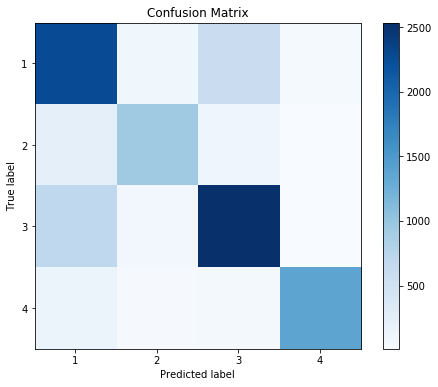

In [41]:
labels=range(1,5)
rates=confusion_matrix(y_true=enc.categories, y_pred= myPredsTrain[:,0], labels=labels)
#plot heatmap
cmap = 'hot'
cmap='Blues'

plt.figure(figsize=(8, 6))
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.imshow(rates, cmap, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

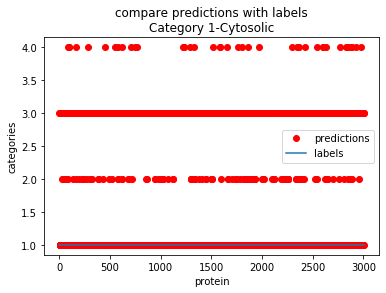

<Figure size 2160x720 with 0 Axes>

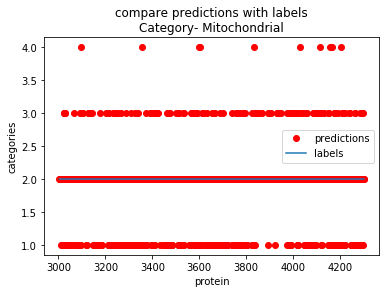

<Figure size 2160x720 with 0 Axes>

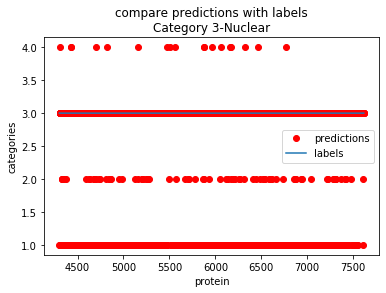

<Figure size 2160x720 with 0 Axes>

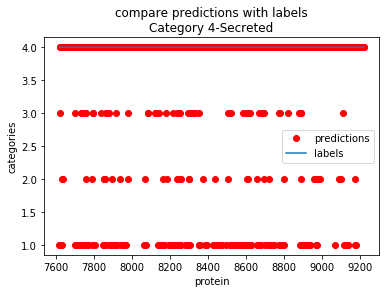

<Figure size 2160x720 with 0 Axes>

In [42]:
predictions=myPredsTrain[:,0]
x=np.arange(len(dataCyto))
y1=predictions[0:len(dataCyto)]
y2=enc.categories[0:len(dataCyto)]
x1=x
x2=x
plt.plot(x1, y1, 'ro',label = "predictions")
plt.plot(x2, y2, label = "labels")
plt.xlabel('protein')
plt.ylabel('categories')
plt.title('compare predictions with labels\nCategory 1-Cytosolic')
plt.legend()
plt.figure(figsize=(30,10))
plt.show()

x=np.arange(len(dataCyto),len(dataCyto)+len(dataMito))
y1=predictions[len(dataCyto):len(dataCyto)+len(dataMito)]
y2=enc.categories[len(dataCyto):len(dataCyto)+len(dataMito)]
x1=x
x2=x
plt.plot(x1, y1, 'ro',label = "predictions")
plt.plot(x2, y2, label = "labels")
plt.xlabel('protein')
plt.ylabel('categories')
plt.title('compare predictions with labels\nCategory- Mitochondrial')
plt.legend()
plt.figure(figsize=(30,10))
plt.show()

x=np.arange(len(dataCyto)+len(dataMito),len(dataCyto)+len(dataMito)+len(dataNucleus))
y1=predictions[len(dataCyto)+len(dataMito):len(dataCyto)+len(dataMito)+len(dataNucleus)]
y2=enc.categories[len(dataCyto)+len(dataMito):len(dataCyto)+len(dataMito)+len(dataNucleus)]
x1=x
x2=x
plt.plot(x1, y1, 'ro',label = "predictions")
plt.plot(x2, y2, label = "labels")
plt.xlabel('protein')
plt.ylabel('categories')
plt.title('compare predictions with labels\nCategory 3-Nuclear')
plt.legend()
plt.figure(figsize=(30,10))
plt.show()

x=np.arange(len(dataCyto)+len(dataMito)+len(dataNucleus), 9222)
y1=predictions[len(dataCyto)+len(dataMito)+len(dataNucleus):]
y2=enc.categories[len(dataCyto)+len(dataMito)+len(dataNucleus):]
x1=x
x2=x
plt.plot(x1, y1, 'ro',label = "predictions")
plt.plot(x2, y2, label = "labels")
plt.xlabel('protein')
plt.ylabel('categories')
plt.title('compare predictions with labels\nCategory 4-Secreted')
plt.legend()
plt.figure(figsize=(30,10))
plt.show()



# Testing

## Make some predictions

In [43]:
print('model 1:')
print('prediction:', model.predict([composition[0]]))
print('probClass1, probClass2, probClass3, probClass 4')
print(model.predict_proba([composition[0]]))
print('\nmodel 6:')
print('prediction:', model6.predict([composition[0]]))
print('probClass1, probClass2, probClass3, probClass 4')
print(model6.predict_proba([composition[0]]))

model 1:
prediction: [1.]
probClass1, probClass2, probClass3, probClass 4
[[0.46911443 0.0383588  0.46527591 0.02725086]]

model 6:
prediction: [3.]
probClass1, probClass2, probClass3, probClass 4
[[0.42489438 0.04610659 0.48956874 0.03943029]]


## Analyse test data

In [44]:
dataBlind=[]
for record in SeqIO.parse("blind.fasta.txt", "fasta"):
    dataBlind.append(record)
print('blind:', len(dataBlind))

blind: 20


In [45]:
blind=[]
for i in range(len(dataBlind)):
    analysed_seq=ProteinAnalysis(str(dataBlind[i].seq))
    blind.append(analysed_seq)

In [46]:
compBlind=np.zeros((len(dataBlind), 20))
for i in range(len(dataBlind)):
    dict=blind[i].get_amino_acids_percent()
    for pos,aa in enumerate(dict.values()):
        compBlind[i,pos]=aa

## Calculcate predictions for NuSVC model

In [47]:

preds=np.zeros(len(dataBlind))
for i in range(len(dataBlind)):
    preds[i]=model.predict([compBlind[i]])
    
probs=np.zeros((len(dataBlind), 4))
for i in range(len(dataBlind)):
    probs[i]=model.predict_proba([compBlind[i]])
    
predProbs=np.array(np.argmax(probs, axis=1)+1)

In [48]:
predProbs

array([1, 4, 4, 1, 4, 3, 1, 1, 1, 1, 2, 3, 4, 1, 3, 3, 4, 1, 1, 3])

In [49]:
print("Predictions for SVC model")
for i in range(len(dataBlind)):
    if preds[i]==predProbs[i]:
        print('index:', i, 'prediction:', preds[i])
    else:
        print('index:',i, 'predicts:', preds[i], 'from probability:', predProbs[i], probs[i, int(predProbs[i]-1)])

Predictions for SVC model
index: 0 prediction: 1.0
index: 1 prediction: 4.0
index: 2 prediction: 4.0
index: 3 prediction: 1.0
index: 4 prediction: 4.0
index: 5 prediction: 3.0
index: 6 predicts: 2.0 from probability: 1 0.37694485726362037
index: 7 prediction: 1.0
index: 8 prediction: 1.0
index: 9 prediction: 1.0
index: 10 prediction: 2.0
index: 11 prediction: 3.0
index: 12 prediction: 4.0
index: 13 prediction: 1.0
index: 14 prediction: 3.0
index: 15 prediction: 3.0
index: 16 prediction: 4.0
index: 17 prediction: 1.0
index: 18 prediction: 1.0
index: 19 prediction: 3.0


In [50]:
for i in range(len(dataBlind)):
    if preds[i]==1:
        print(dataBlind[i].name, 'Cytosolic, Confidence', np.round(np.max(probs[i])*100), '%')
    elif preds[i]==2:
        print(dataBlind[i].name, 'Mitochondrial, Confidence', np.round(np.max(probs[i])*100), '%')
    elif preds[i]==3:
        print(dataBlind[i].name, 'Nuclear, Confidence', np.round(np.max(probs[i])*100), '%')
    elif preds[i]==4:
        print(dataBlind[i].name, 'Secreted, Confidence', np.round(np.max(probs[i])*100), '%')
        

SEQ677 Cytosolic, Confidence 46.0 %
SEQ231 Secreted, Confidence 75.0 %
SEQ871 Secreted, Confidence 55.0 %
SEQ388 Cytosolic, Confidence 46.0 %
SEQ122 Secreted, Confidence 64.0 %
SEQ758 Nuclear, Confidence 55.0 %
SEQ333 Mitochondrial, Confidence 38.0 %
SEQ937 Cytosolic, Confidence 69.0 %
SEQ351 Cytosolic, Confidence 45.0 %
SEQ202 Cytosolic, Confidence 40.0 %
SEQ608 Mitochondrial, Confidence 52.0 %
SEQ402 Nuclear, Confidence 46.0 %
SEQ433 Secreted, Confidence 99.0 %
SEQ821 Cytosolic, Confidence 46.0 %
SEQ322 Nuclear, Confidence 67.0 %
SEQ982 Nuclear, Confidence 71.0 %
SEQ951 Secreted, Confidence 35.0 %
SEQ173 Cytosolic, Confidence 53.0 %
SEQ862 Cytosolic, Confidence 42.0 %
SEQ224 Nuclear, Confidence 68.0 %


## Calculcate predictions for combined model

In [51]:
preds6=np.zeros(len(dataBlind))
for i in range(len(dataBlind)):
    preds6[i]=model6.predict([compBlind[i]])
    
probs6=np.zeros((len(dataBlind), 4))
for i in range(len(dataBlind)):
    probs6[i]=model6.predict_proba([compBlind[i]])
    
predProbs6=np.array(np.argmax(probs6, axis=1)+1)

In [52]:
print("Predictions for combined model")
for i in range(len(dataBlind)):
    if preds6[i]==predProbs6[i]:
        print('index:', i, 'prediction:', preds6[i])
    else:
        print('index:',i, 'predicts:', preds6[i], 'from probability:', predProbs6[i], probs6[i,int(predProbs6[i]-1)])
        

Predictions for combined model
index: 0 predicts: 4.0 from probability: 1 0.38485204262738076
index: 1 prediction: 4.0
index: 2 prediction: 4.0
index: 3 prediction: 1.0
index: 4 prediction: 4.0
index: 5 prediction: 3.0
index: 6 prediction: 2.0
index: 7 prediction: 1.0
index: 8 prediction: 1.0
index: 9 predicts: 2.0 from probability: 1 0.3559566482274185
index: 10 prediction: 2.0
index: 11 prediction: 3.0
index: 12 prediction: 4.0
index: 13 prediction: 1.0
index: 14 prediction: 3.0
index: 15 prediction: 3.0
index: 16 predicts: 4.0 from probability: 3 0.36998374800371653
index: 17 prediction: 1.0
index: 18 prediction: 1.0
index: 19 prediction: 3.0


In [53]:
for i in range(len(dataBlind)):
    if preds6[i]==1:
        print(dataBlind[i].name, 'Cytosolic, Confidence', np.round(np.max(probs6[i])*100), '%')
    elif preds6[i]==2:
        print(dataBlind[i].name, 'Mitochondrial, Confidence', np.round(np.max(probs6[i])*100), '%')
    elif preds6[i]==3:
        print(dataBlind[i].name, 'Nuclear, Confidence', np.round(np.max(probs6[i])*100), '%')
    elif preds6[i]==4:
        print(dataBlind[i].name, 'Secreted, Confidence', np.round(np.max(probs6[i])*100), '%')
        


SEQ677 Secreted, Confidence 38.0 %
SEQ231 Secreted, Confidence 61.0 %
SEQ871 Secreted, Confidence 51.0 %
SEQ388 Cytosolic, Confidence 44.0 %
SEQ122 Secreted, Confidence 43.0 %
SEQ758 Nuclear, Confidence 57.0 %
SEQ333 Mitochondrial, Confidence 39.0 %
SEQ937 Cytosolic, Confidence 69.0 %
SEQ351 Cytosolic, Confidence 41.0 %
SEQ202 Mitochondrial, Confidence 36.0 %
SEQ608 Mitochondrial, Confidence 46.0 %
SEQ402 Nuclear, Confidence 45.0 %
SEQ433 Secreted, Confidence 82.0 %
SEQ821 Cytosolic, Confidence 52.0 %
SEQ322 Nuclear, Confidence 66.0 %
SEQ982 Nuclear, Confidence 80.0 %
SEQ951 Secreted, Confidence 37.0 %
SEQ173 Cytosolic, Confidence 45.0 %
SEQ862 Cytosolic, Confidence 42.0 %
SEQ224 Nuclear, Confidence 60.0 %


## Compare the two predictions

In [54]:
## if the two models agree then great, otherwise pick the prediction with max probability
print("Compare two predictions:")
myPreds=np.zeros((len(dataBlind), 2))

for i in range(len(dataBlind)):
    if preds[i]==preds6[i]:
        ans=preds[i]
        ansprob=max(probs[i, int(preds[i]-1)], probs6[i, int(preds6[i]-1)])
        print('index:', i, 'prediction:', ans, 'with prob', ansprob)
    else:
        a=np.max(probs[i])
        b=np.max(probs6[i])
        if a>b:
            ans=np.argmax(probs[i])+1
            ansprob=np.max(probs[i])
        else:
            ans=np.argmax(probs6[i])+1
            ansprob=np.max(probs6[i])
        print('index:',i, 'decide', ans, 'with prob', ansprob)
    myPreds[i]=ans,ansprob

Compare two predictions:
index: 0 decide 1 with prob 0.46479573742752245
index: 1 prediction: 4.0 with prob 0.7511174737621287
index: 2 prediction: 4.0 with prob 0.552585390415783
index: 3 prediction: 1.0 with prob 0.4588595917157157
index: 4 prediction: 4.0 with prob 0.6370291183739843
index: 5 prediction: 3.0 with prob 0.5717144404198428
index: 6 prediction: 2.0 with prob 0.3869057337474161
index: 7 prediction: 1.0 with prob 0.6925715030285949
index: 8 prediction: 1.0 with prob 0.4511865829276436
index: 9 decide 1 with prob 0.4039928268318301
index: 10 prediction: 2.0 with prob 0.5213453903216065
index: 11 prediction: 3.0 with prob 0.46283552265431516
index: 12 prediction: 4.0 with prob 0.9938994156180484
index: 13 prediction: 1.0 with prob 0.5183125436060017
index: 14 prediction: 3.0 with prob 0.6651989692070015
index: 15 prediction: 3.0 with prob 0.7955694177857213
index: 16 prediction: 4.0 with prob 0.34924163966033067
index: 17 prediction: 1.0 with prob 0.5262799893747406
index: 

In [55]:
print(myPreds)

[[1.         0.46479574]
 [4.         0.75111747]
 [4.         0.55258539]
 [1.         0.45885959]
 [4.         0.63702912]
 [3.         0.57171444]
 [2.         0.38690573]
 [1.         0.6925715 ]
 [1.         0.45118658]
 [1.         0.40399283]
 [2.         0.52134539]
 [3.         0.46283552]
 [4.         0.99389942]
 [1.         0.51831254]
 [3.         0.66519897]
 [3.         0.79556942]
 [4.         0.34924164]
 [1.         0.52627999]
 [1.         0.41808161]
 [3.         0.67728298]]


## Final Predictions

In [56]:
for i in range(len(dataBlind)):
    if myPreds[i,0]==1:
        print(dataBlind[i].name, 'Cytosolic, Confidence', np.round(myPreds[i,1]*100, 1), '%')
    elif myPreds[i,0]==2:
        print(dataBlind[i].name, 'Mitochondrial, Confidence', np.round(myPreds[i,1]*100,1), '%')
    elif myPreds[i,0]==3:
        print(dataBlind[i].name, 'Nuclear, Confidence', np.round(myPreds[i,1]*100,1), '%')
    elif myPreds[i,0]==4:
        print(dataBlind[i].name, 'Secreted, Confidence', np.round(myPreds[i,1]*100,1), '%')
        
        



SEQ677 Cytosolic, Confidence 46.5 %
SEQ231 Secreted, Confidence 75.1 %
SEQ871 Secreted, Confidence 55.3 %
SEQ388 Cytosolic, Confidence 45.9 %
SEQ122 Secreted, Confidence 63.7 %
SEQ758 Nuclear, Confidence 57.2 %
SEQ333 Mitochondrial, Confidence 38.7 %
SEQ937 Cytosolic, Confidence 69.3 %
SEQ351 Cytosolic, Confidence 45.1 %
SEQ202 Cytosolic, Confidence 40.4 %
SEQ608 Mitochondrial, Confidence 52.1 %
SEQ402 Nuclear, Confidence 46.3 %
SEQ433 Secreted, Confidence 99.4 %
SEQ821 Cytosolic, Confidence 51.8 %
SEQ322 Nuclear, Confidence 66.5 %
SEQ982 Nuclear, Confidence 79.6 %
SEQ951 Secreted, Confidence 34.9 %
SEQ173 Cytosolic, Confidence 52.6 %
SEQ862 Cytosolic, Confidence 41.8 %
SEQ224 Nuclear, Confidence 67.7 %


# Further testing
**(only run if you want to test on further data)**

### Analyse the data

In [ ]:
furtherData=[]

####change the filename to match the file you want to test
##For further information see README.md
for record in SeqIO.parse("filename.txt", "fasta"):
    furtherData.append(record)
print('furtherData:', len(furtherData))

furtherSequences=[]
for i in range(len(furtherData)):
    analysed_seq=ProteinAnalysis(str(furtherData[i].seq))
    furtherSequences.append(analysed_seq)
    
compFurther=np.zeros((len(furtherData), 20))
for i in range(len(furtherData)):
    dict=furtherSequences[i].get_amino_acids_percent()
    for pos,aa in enumerate(dict.values()):
        compFurther[i,pos]=aa

### Make predictions on further data

In [ ]:
#model 1
predsF=np.zeros(len(furtherData))
for i in range(len(furtherData)):
    predsF[i]=model.predict([compFurther[i]])
    
probsF=np.zeros((len(furtherData), 4))
for i in range(len(furtherData)):
    probsF[i]=model.predict_proba([compFurther[i]])
    
predProbsF=np.array(np.argmax(probsF, axis=1)+1)

#model 6
preds6F=np.zeros(len(furtherData))
for i in range(len(furtherData)):
    preds6F[i]=model6.predict([compFurther[i]])
    
probs6F=np.zeros((len(furtherData), 4))
for i in range(len(furtherData)):
    probs6F[i]=model6.predict_proba([compFurther[i]])
    
predProbs6F=np.array(np.argmax(probs6F, axis=1)+1)


print("Predictions:")
myPredsF=np.zeros((len(furtherData), 2))

for i in range(len(furtherData)):
    if predsF[i]==preds6F[i]:
        ans=predsF[i]
        ansprob=max(probsF[i, int(predsF[i]-1)], probs6F[i, int(preds6F[i]-1)])
    else:
        a=np.max(probsF[i])
        b=np.max(probs6F[i])
        if a>b:
            ans=np.argmax(probsF[i])+1
            ansprob=np.max(probsF[i])
        else:
            ans=np.argmax(probs6F[i])+1
            ansprob=np.max(probs6F[i])
    myPredsF[i]=ans,ansprob
    
for i in range(len(furtherData)):
    if myPredsF[i,0]==1:
        print(furtherData[i].name, 'Cytosolic, Confidence', np.round(myPredsF[i,1]*100), '%')
    elif myPredsF[i,0]==2:
        print(furtherData[i].name, 'Mitochondrial, Confidence', np.round(myPredsF[i,1]*100), '%')
    elif myPredsF[i,0]==3:
        print(furtherData[i].name, 'Nuclear, Confidence', np.round(myPredsF[i,1]*100), '%')
    elif myPredsF[i,0]==4:
        print(furtherData[i].name, 'Secreted, Confidence', np.round(myPredsF[i,1]*100), '%')
        